# Analysis Processed Slocum Glider-AD2CP Data: RU29 2020

In [1]:
# Imports
import scipy.interpolate as interp
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [2]:
ds_id = 'ru29-20200908T1623-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
variables2 = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf.columns = variables2


## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

## Format time
gdf.time = pd.to_datetime(gdf.time.values).tz_localize(None).values

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,temperature,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.00000,18.175290,-64.802942,2020-09-08 16:23:40.150,0.0000,0.00000,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
1,0.00000,18.175290,-64.802942,2020-09-08 16:23:47.430,0.0000,0.00000,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
2,NaN,18.175290,-64.802942,2020-09-08 16:23:47.560,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,1.80293
3,NaN,18.175290,-64.802942,2020-09-08 16:24:48.430,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,1.80293
4,NaN,18.176045,-64.804093,2020-09-08 16:25:14.450,NaN,NaN,ru29-2020-251-4-0-mbd(04270000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5087216,0.18886,18.139090,-64.784373,2020-11-12 07:31:32.760,27.6073,5.43973,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087217,0.18886,18.139090,-64.784373,2020-11-12 07:31:34.770,27.6072,5.43980,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087218,0.14910,18.139090,-64.784373,2020-11-12 07:31:36.790,27.6093,5.43990,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN
5087219,0.15904,18.139090,-64.784373,2020-11-12 07:31:38.800,27.6093,5.43993,ru29-2020-315-0-9-mbd(04470009),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [3]:
path = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Processed/"
files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df

,Unnamed: 0,inversion_u,inversion_v,inversion_depth,longitude,latitude,start_tm,end_tm
0,0,-0.178435,0.038016,2.5,-64.812207,18.085657,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z
1,1,-0.180796,0.035540,7.5,-64.812207,18.085657,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z
2,2,-0.193859,0.021301,12.5,-64.812207,18.085657,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z
3,3,-0.214329,0.024390,17.5,-64.812207,18.085657,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z
4,4,-0.229046,0.037650,22.5,-64.812207,18.085657,2020-10-02T07:40:09.21Z,2020-10-02T10:42:47.00Z
...,...,...,...,...,...,...,...,...
193,193,-0.107159,0.010629,967.5,-64.789935,18.110432,2020-11-07T17:09:26.21Z,2020-11-07T20:12:16.23Z
194,194,-0.107012,0.011479,972.5,-64.789935,18.110432,2020-11-07T17:09:26.21Z,2020-11-07T20:12:16.23Z
195,195,-0.108476,0.010197,977.5,-64.789935,18.110432,2020-11-07T17:09:26.21Z,2020-11-07T20:12:16.23Z
196,196,-0.106320,0.012747,982.5,-64.789935,18.110432,2020-11-07T17:09:26.21Z,2020-11-07T20:12:16.23Z


In [4]:
inversion_depth   = np.arange(2.5,1030,5)
inversion_lat    = np.empty(len(files))
inversion_lat[:] = np.NaN
inversion_lon    = np.empty(len(files))
inversion_lon[:] = np.NaN
inversion_time    = np.empty(len(files))
inversion_time[:] = np.NaN
inversion_time = inversion_time.astype(pd.Timestamp)


u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file

for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    inversion_lat[x] = df.latitude.values[0]
    inversion_lon[x] = df.longitude.values[0]
    inversion_time[x] = pd.to_datetime(df.start_tm.values[0])

inversion_time = np.sort(inversion_time)

/tmp/ipykernel_19357/990015670.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(inversion_time,inversion_depth,u_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)


Text(0.5, 1.0, 'RU29 2020 St. Thomas-St. Croix')

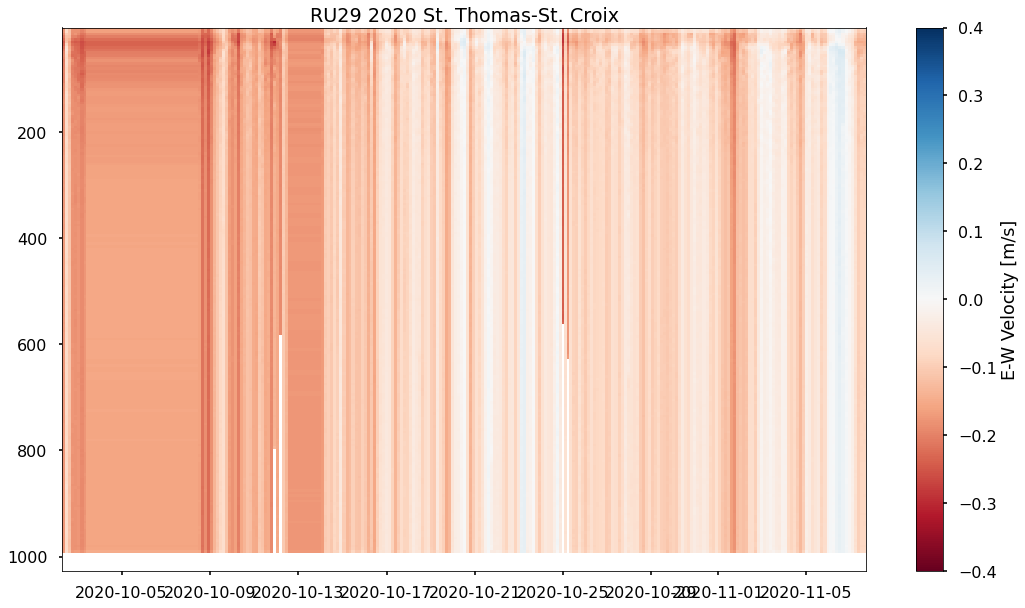

In [5]:
plt.figure(figsize=(18,10))
plt.pcolormesh(inversion_time,inversion_depth,u_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)
#plt.pcolormesh(u_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2020 St. Thomas-St. Croix')

/tmp/ipykernel_19357/3764486125.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(inversion_time,inversion_depth,v_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)


Text(0.5, 1.0, 'RU29 2020 St. Thomas-St. Croix')

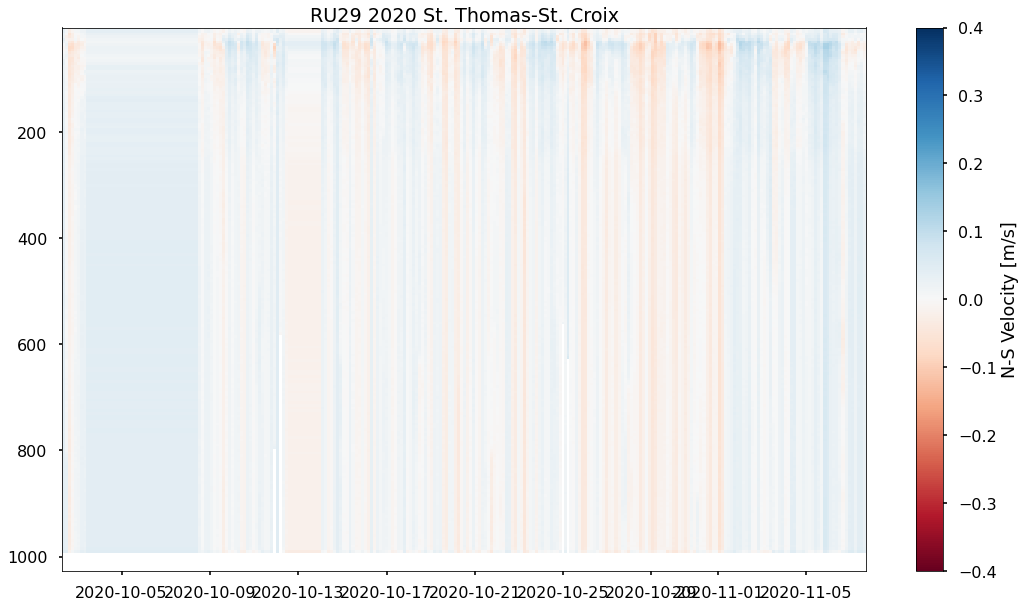

In [6]:
plt.figure(figsize=(18,10))
plt.pcolormesh(inversion_time,inversion_depth,v_grid,cmap='RdBu',vmin=-0.4,vmax=0.4)
plt.gca().invert_yaxis()
plt.colorbar(label='N-S Velocity [m/s]')
plt.title('RU29 2020 St. Thomas-St. Croix')

## Section Timing

In [33]:
sect_times1 = pd.read_csv('/home/jg1200/Data/GliderData/RU29/anagada_section_times.csv')
sect_times1.starttime = np.array(sect_times1.starttime,dtype=np.datetime64)
sect_times1.endtime = np.array(sect_times1.endtime,dtype=np.datetime64)
sect_times = sect_times1.iloc[7:-1,:]
sect_times

,section_number,starttime,endtime
7,7,2020-10-15 09:07:30,2020-10-17 00:31:58
8,8,2020-10-17 00:31:58,2020-10-18 13:53:20
9,9,2020-10-18 13:53:20,2020-10-20 06:44:54
10,10,2020-10-20 06:44:54,2020-10-21 17:10:48
11,11,2020-10-21 17:10:48,2020-10-23 07:00:58
12,12,2020-10-23 07:00:58,2020-10-24 18:42:06
13,13,2020-10-24 18:42:06,2020-10-26 10:57:09
14,14,2020-10-26 10:57:09,2020-10-27 21:53:33
15,15,2020-10-27 21:53:33,2020-10-29 15:06:27
16,16,2020-10-29 15:06:27,2020-10-31 03:11:10


## Subset to just transects

## Glider data first

In [34]:
gdf_sect = gdf.loc[(gdf.time >= sect_times.starttime.values[0]) & (gdf.time <= sect_times.endtime.values[-1])]

gdf_sect

,depth,latitude,longitude,time,temperature,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
2404112,367.29800,17.822814,-64.796579,2020-10-15 09:07:30.140,14.4201,4.34057,ru29-2020-274-1-201-mbd(04450201),NaN,NaN,NaN
2404113,366.87134,17.822812,-64.796578,2020-10-15 09:07:32.150,14.4308,4.34189,ru29-2020-274-1-201-mbd(04450201),NaN,NaN,NaN
2404114,NaN,17.822811,-64.796578,2020-10-15 09:07:32.750,NaN,NaN,ru29-2020-274-1-201-mbd(04450201),NaN,NaN,0.584685
2404115,366.44470,17.822810,-64.796577,2020-10-15 09:07:34.160,14.4429,4.34368,ru29-2020-274-1-201-mbd(04450201),NaN,NaN,NaN
2404116,366.02795,17.822808,-64.796576,2020-10-15 09:07:36.170,14.4726,4.34681,ru29-2020-274-1-201-mbd(04450201),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4253965,384.02972,18.146276,-64.783751,2020-11-08 01:52:19.450,15.6457,4.49492,ru29-2020-274-1-544-mbd(04450544),NaN,NaN,NaN
4253966,NaN,18.146276,-64.783750,2020-11-08 01:52:20.020,NaN,NaN,ru29-2020-274-1-544-mbd(04450544),NaN,NaN,2.975790
4253967,383.62292,18.146277,-64.783749,2020-11-08 01:52:21.460,15.6592,4.49589,ru29-2020-274-1-544-mbd(04450544),NaN,NaN,NaN
4253968,383.20624,18.146279,-64.783748,2020-11-08 01:52:23.480,15.6629,4.49639,ru29-2020-274-1-544-mbd(04450544),NaN,NaN,NaN


## AD2CP data next

In [35]:
sect_adcp_time_ind = np.where((pd.to_datetime(inversion_time).tz_localize(None).values >= sect_times.starttime.values[0]) & (pd.to_datetime(inversion_time).tz_localize(None).values <= sect_times.endtime.values[-1]))
inversion_sect_time = inversion_time[sect_adcp_time_ind[0]]
u_grid_sect = u_grid[:,sect_adcp_time_ind[0]]
v_grid_sect = v_grid[:,sect_adcp_time_ind[0]]
inversion_lon_sect = inversion_lon[sect_adcp_time_ind[0]]
inversion_lat_sect = inversion_lat[sect_adcp_time_ind[0]]


## Make a grid for the mean position of the transects

Text(0.5, 1.0, 'Glider Surfacing Position During Transect')

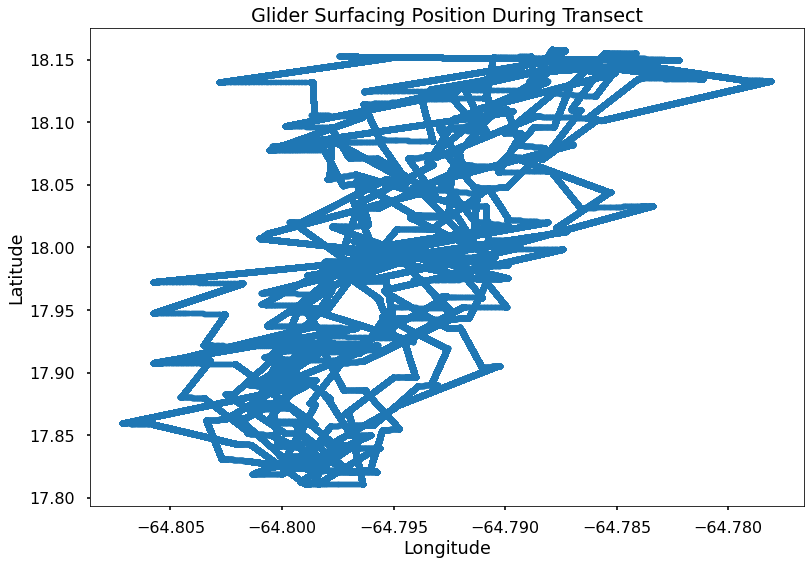

In [36]:
plt.plot(gdf_sect.longitude,gdf_sect.latitude,'.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Glider Surfacing Position During Transect')

## Make a grid for interpolation

In [62]:
#lat_grid
lat_grid = np.arange(17.8,18.16,0.05)
#lon_grid
lon_grid = np.repeat(-64.80,8) # Just make it -64.80
## Make grid
X, Y, Z = np.meshgrid(lon_grid, lat_grid, inversion_depth)

## This works for one transect
gridvelu = np.empty((len(inversion_depth),len(lat_grid),15))
gridvelu[:] = np.NaN
gridvelv = np.empty((len(inversion_depth),len(lat_grid),15))
gridvelv[:] = np.NaN


## The last profile is kind of weird so only doing 0:15 for now, not 0:16
for y in np.arange(0,15):
    #z = np.arange(7,22)
    
    ## ADCP
    subset_sect_adcp_time_ind = np.where((pd.to_datetime(inversion_sect_time).tz_localize(None).values >= sect_times.starttime.values[y]) & (pd.to_datetime(inversion_sect_time).tz_localize(None).values <= sect_times.endtime.values[y]))
    subset_v_grid_sect = v_grid_sect[:,subset_sect_adcp_time_ind[0]]
    subset_u_grid_sect = u_grid_sect[:,subset_sect_adcp_time_ind[0]]
    subset_inversion_lat_sect = inversion_lat_sect[subset_sect_adcp_time_ind[0]]
    #print(subset_inversion_lat_sect)

    for x in np.arange(0,len(inversion_depth)):
        gridvelu[x,:,y] = interp.griddata(subset_inversion_lat_sect, subset_u_grid_sect[x,:], lat_grid, method='nearest')
        gridvelv[x,:,y] = interp.griddata(subset_inversion_lat_sect, subset_v_grid_sect[x,:], lat_grid, method='nearest')

        
meangridu = np.nanmean(gridvelu,axis=2)
meangridv = np.nanmean(gridvelv,axis=2)
stdgridu  = np.nanstd(gridvelu, axis=2)
stdgridv  = np.nanstd(gridvelv, axis=2)

/tmp/ipykernel_19357/2330087056.py:31: RuntimeWarning: Mean of empty slice
  meangridu = np.nanmean(gridvelu,axis=2)
/tmp/ipykernel_19357/2330087056.py:32: RuntimeWarning: Mean of empty slice
  meangridv = np.nanmean(gridvelv,axis=2)
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Temporal Mean E-W Velocity')

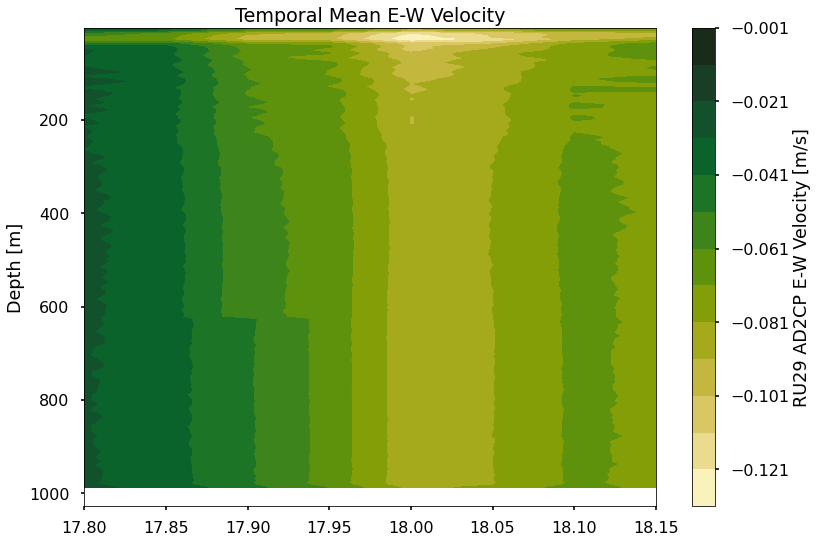

In [63]:
plt.contourf(lat_grid,inversion_depth,meangridu,cmap=cmo.speed,levels=np.arange(-0.131, 0, 0.01))
plt.gca().invert_yaxis()
plt.colorbar(label='RU29 AD2CP E-W Velocity [m/s]');
plt.ylabel('Depth [m]')
plt.title('Temporal Mean E-W Velocity')

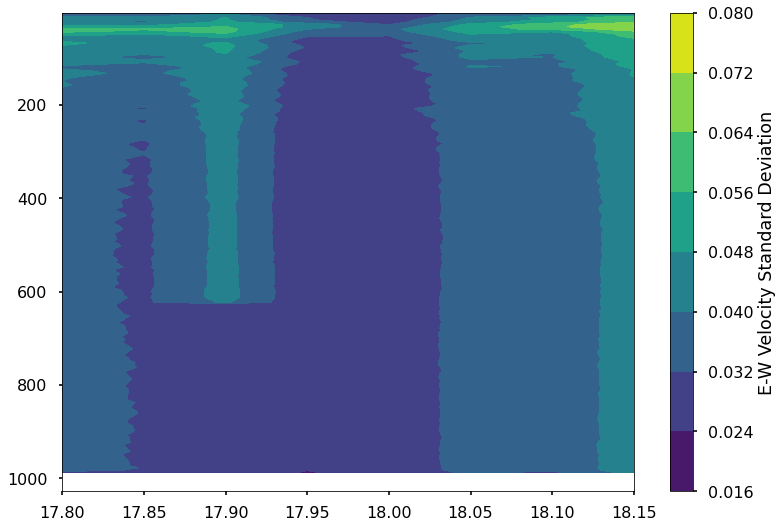

In [64]:
plt.contourf(lat_grid,inversion_depth,stdgridu)#levels=np.arange(0, 0.076, 0.005))
plt.colorbar(label='E-W Velocity Standard Deviation')
plt.gca().invert_yaxis()
#plt.ylim(250,0)

Text(0.5, 1.0, 'Temporal Mean N-S Velocity')

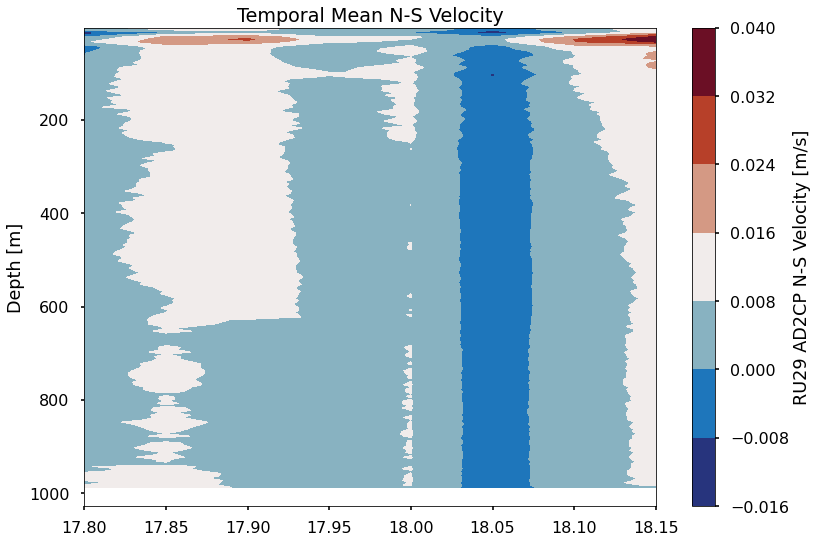

In [65]:
plt.contourf(lat_grid,inversion_depth,meangridv,cmap=cmo.balance)#levels=np.arange(-0.04, 0.051, 0.005))
plt.gca().invert_yaxis()
#plt.ylim(250,0)
plt.colorbar(label='RU29 AD2CP N-S Velocity [m/s]');
plt.ylabel('Depth [m]')
plt.title('Temporal Mean N-S Velocity')

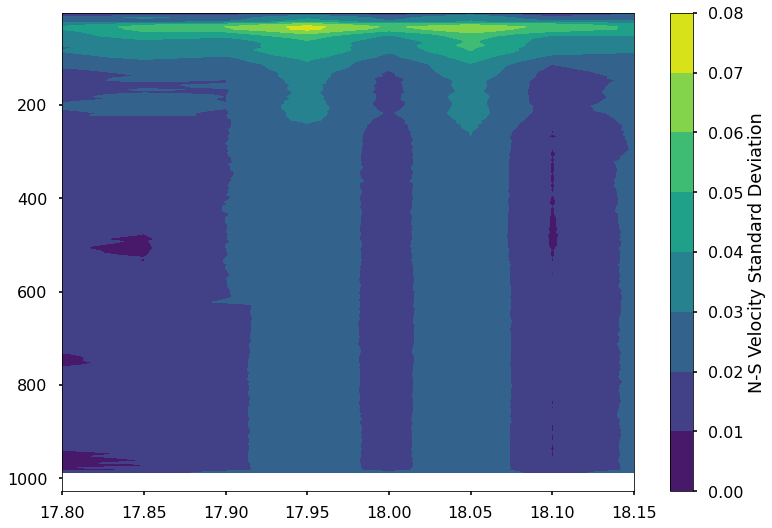

In [66]:
plt.contourf(lat_grid,inversion_depth,stdgridv)#levels=np.arange(0, 0.076, 0.005))
plt.colorbar(label='N-S Velocity Standard Deviation')
plt.gca().invert_yaxis()
#plt.ylim(250,0)

## Calculate some Transport!

In [67]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(lat_grid[0])
lon1 = radians(lon_grid[0])
lat2 = radians(lat_grid[1])
lon2 = radians(lon_grid[0])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

5561.491661480293

In [68]:
transport_gridu = np.empty(gridvelu.shape[2])
transport_gridv = np.empty(gridvelu.shape[2])

for x in np.arange(0,gridvelu.shape[2]):
    transport_gridu[x] = (np.nansum(gridvelu[:,:,x]*5*distance))/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
    transport_gridv[x] = (np.nansum(gridvelv[:,:,x]*5*distance))/(10**6) # multiply by 5 because of grid cell size

In [69]:
len(transport_gridu)

15

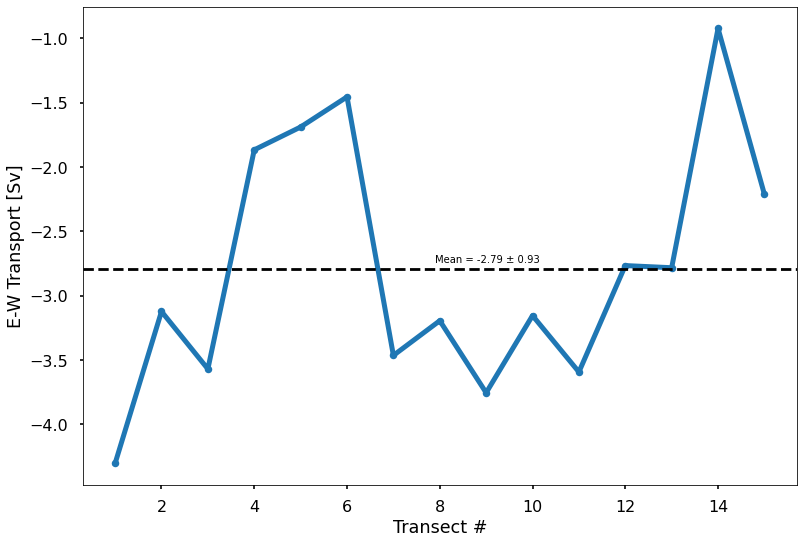

In [70]:
plt.plot(np.arange(1,16),transport_gridu, linewidth=5,color='tab:blue')
plt.plot(np.arange(1,16),transport_gridu, '.',color='tab:blue',markersize=15)
plt.ylabel('E-W Transport [Sv]')
plt.xlabel('Transect #')
plt.axhline(y=np.nanmean(transport_gridu), color='k', linestyle='--')
plt.text(7.9, np.nanmean(transport_gridu)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridu),2),np.round(np.nanstd(transport_gridu),2)));
         

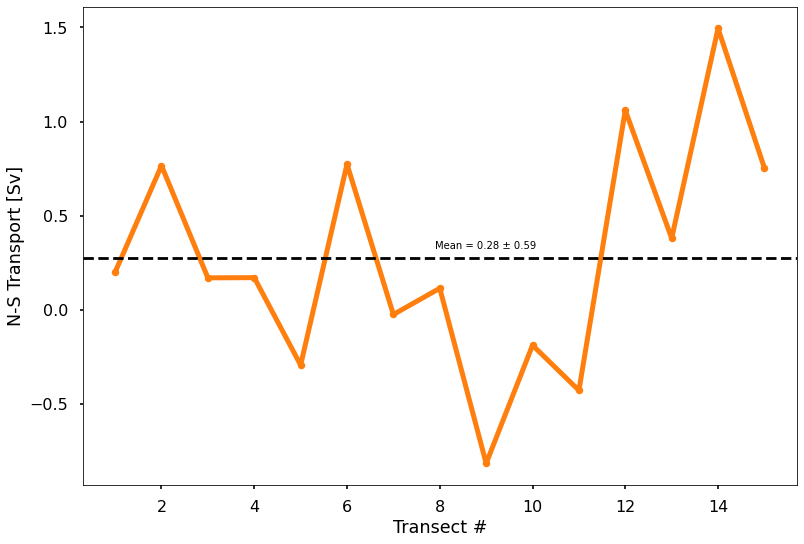

In [71]:
plt.plot(np.arange(1,16),transport_gridv, linewidth=5,color='tab:orange')
plt.plot(np.arange(1,16),transport_gridv, '.',color='tab:orange',markersize=15)
plt.ylabel('N-S Transport [Sv]')
plt.xlabel('Transect #')
plt.axhline(y=np.nanmean(transport_gridv), color='k', linestyle='--')
plt.text(7.9, np.nanmean(transport_gridv)+0.05, "Mean = %s \u00B1 %s" %(np.round(np.nanmean(transport_gridv),2),np.round(np.nanstd(transport_gridv),2)));
         

## Look at just one profile

In [ ]:
x =7

sect_adcp_time_ind = np.where((pd.to_datetime(inversion_time).tz_localize(None).values >= sect_times.starttime.values[x]) & (pd.to_datetime(inversion_time).tz_localize(None).values <= sect_times.endtime.values[x]))
inversion_sect_time = inversion_time[sect_adcp_time_ind[0]]
u_grid_sect = u_grid[:,sect_adcp_time_ind[0]]
v_grid_sect = v_grid[:,sect_adcp_time_ind[0]]
inversion_lon_sect = inversion_lon[sect_adcp_time_ind[0]]
inversion_lat_sect = inversion_lat[sect_adcp_time_ind[0]]

fig, axs = plt.subplots(1,4, figsize=(30, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

counter = 0
for x in np.arange(0,12,3):

    axs[counter].plot(v_grid_sect[:,x], inversion_depth,linewidth=4, color='orange')    
    axs[counter].fill_betweenx(inversion_depth, 0,v_grid_sect[:,x], alpha=0.3,color='orange')
    axs[counter].set_xlabel('Velocity [m/s]')
    axs[counter].set_ylabel('Depth[m]')
    axs[counter].set_ylim(250,0)
    axs[counter].set_xticks([-0.2,-0.1,0,0.1,0.2])
    axs[counter].set_title('End Time: %s' %str(inversion_sect_time[x])[0:16])
    counter = counter+1


In [ ]:
x =7

sect_adcp_time_ind = np.where((pd.to_datetime(inversion_time).tz_localize(None).values >= sect_times.starttime.values[x]) & (pd.to_datetime(inversion_time).tz_localize(None).values <= sect_times.endtime.values[x]))

inversion_sect_time = inversion_time[sect_adcp_time_ind[0]]
u_grid_sect = u_grid[:,sect_adcp_time_ind[0]]
v_grid_sect = v_grid[:,sect_adcp_time_ind[0]]
inversion_lon_sect = inversion_lon[sect_adcp_time_ind[0]]
inversion_lat_sect = inversion_lat[sect_adcp_time_ind[0]]

fig, axs = plt.subplots(1,4, figsize=(30, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()

counter = 0
for x in np.arange(0,12,3):

    axs[counter].plot(u_grid_sect[:,x], inversion_depth,linewidth=4)    
    axs[counter].fill_betweenx(inversion_depth, 0,u_grid_sect[:,x], alpha=0.3)
    axs[counter].set_xlabel('Velocity [m/s]')
    axs[counter].set_ylabel('Depth[m]')
    axs[counter].set_ylim(250,0)
    axs[counter].set_xticks([-0.2,-0.1,0,0.1,0.2])
    axs[counter].set_title('End Time: %s' %str(inversion_sect_time[x])[0:16])
    counter = counter+1


## Plotting for Travis' presentation

In [53]:
## Having a hard time getting this to work because of nans?
# gl_tm, gl_lon, gl_lat, gl_depth, gl_temp = grid_glider_data(gdf, 'temperature', 0.5)
# #gl_tm, gl_lon, gl_lat, gl_depth, gl_salinity = grid_glider_data(gdf, 'salinity', 0.5)
# #gl_tm, gl_lon, gl_lat, gl_depth, gl_density = grid_glider_data(gdf, 'density', 0.5)

In [45]:
## Remove nans for plotting
nanind = np.where(np.isnan(gdf.depth.values)==False)[0]
gtime  = gdf.time.values[nanind]
gdepth = gdf.depth.values[nanind]
gtemp  = gdf.temperature.values[nanind]

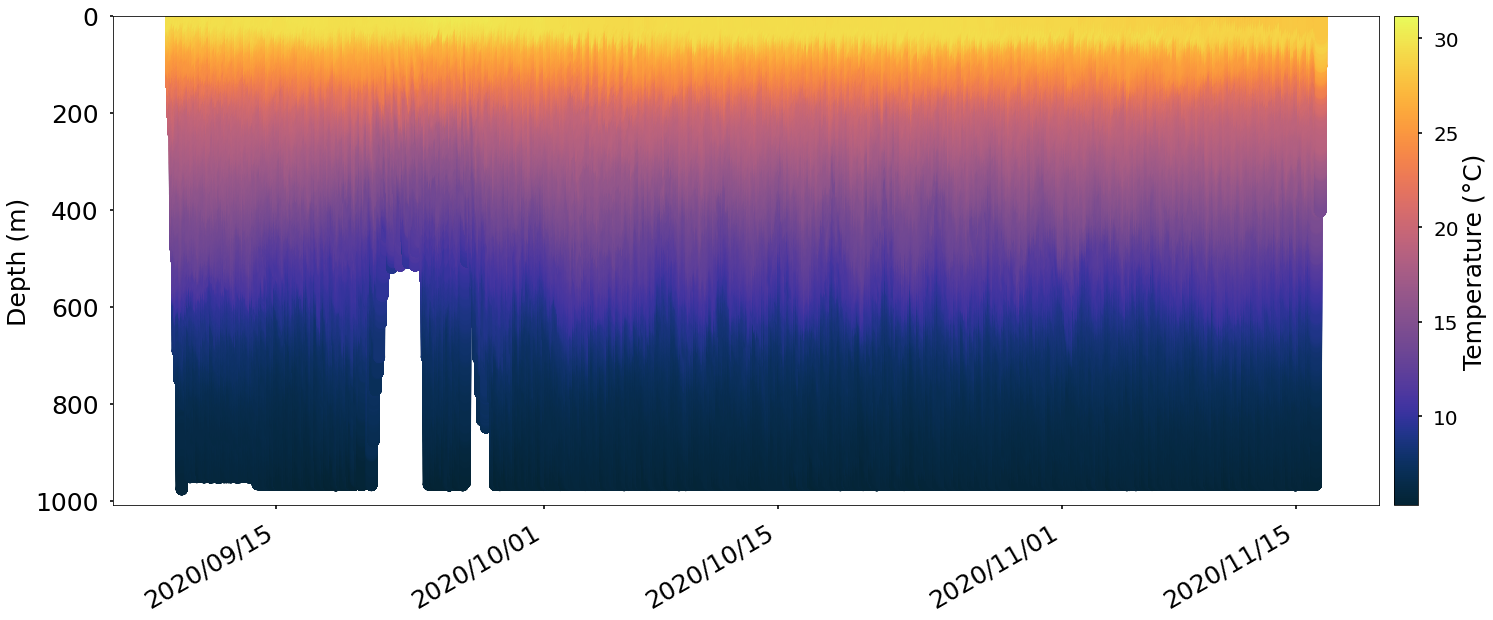

In [52]:
plt.rcParams.update({'font.size': 25})
myFmt = mdates.DateFormatter('%Y/%m/%d')

plt.figure(figsize=(27,10))
plt.scatter(gtime,gdepth,c=gtemp,cmap=cmo.thermal)
cbar = plt.colorbar(pad=0.01)
cbar.set_label(label='Temperature (°C)',size=25)
cbar.ax.tick_params(labelsize=20) 

plt.ylabel('Depth (m)', fontsize = 25)
plt.yticks(fontsize = 25)
plt.xticks(fontsize = 25)
plt.ylim(1010,0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()
#plt.xlim(pd.to_datetime(gl_tm2[63]),pd.to_datetime(gl_tm2[140]))
#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Temperature_Subset.png',dpi=300)

/tmp/ipykernel_10100/4152382517.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values, 'k',linewidth=2, transform=ccrs.PlateCarree(),color='red')
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


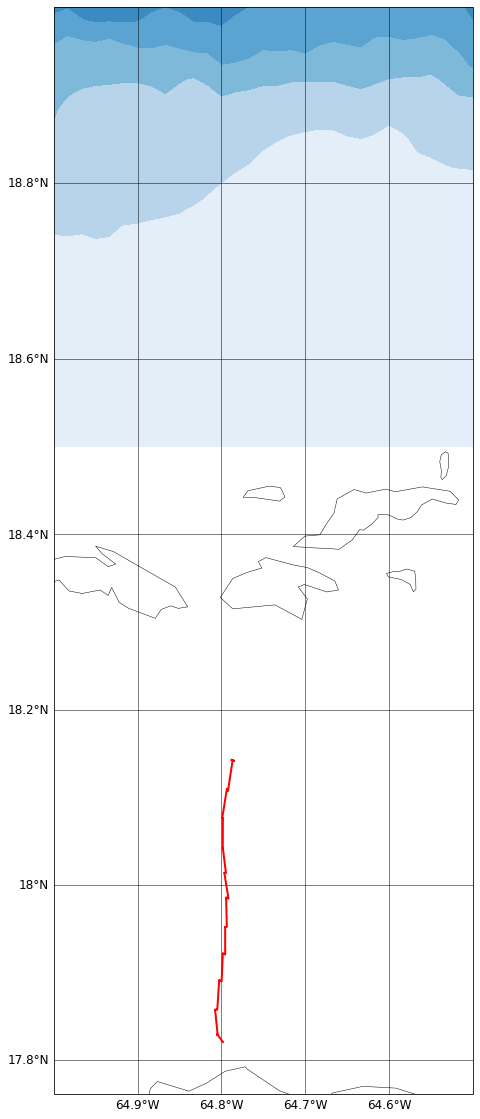

In [70]:
# grab bathymetry data for a map
import cartopy.crs as ccrs

## Zoomed window
#lat_lims = [16, 19]
#lon_lims = [-66.5, -60.5]
lat_lims = [18.5, 19]
lon_lims = [-65, -64.5]


# grab some bathymetry
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

fig = plt.figure(figsize=(15,20))
ax = plt.subplot( projection= ccrs.Mercator())

## Good but too smooth
#dpth_contours = np.arange(-8500, 1, 500)

dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 

#plt.plot(gdf.longitude.values, gdf.latitude.values, 'k',linewidth=6, transform=ccrs.PlateCarree(),color='black')



x =2
gdf_sect = gdf.loc[(gdf.time >= sect_times.starttime.values[x]) & (gdf.time <= sect_times.endtime.values[x])]
sect_adcp_time_ind = np.where((pd.to_datetime(inversion_time).tz_localize(None).values >= sect_times.starttime.values[x]) & (pd.to_datetime(inversion_time).tz_localize(None).values <= sect_times.endtime.values[x]))

inversion_lon_sect = inversion_lon[sect_adcp_time_ind[0]]
inversion_lat_sect = inversion_lat[sect_adcp_time_ind[0]]

#plt.plot(inversion_lon_sect, inversion_lat_sect, 'k',linewidth=2, transform=ccrs.PlateCarree(),color='black')
plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values, 'k',linewidth=2, transform=ccrs.PlateCarree(),color='red')



plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
#plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.055)
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

## Mean transect profiles compared to RTOFS now

In [59]:
f = '/home/jg1200/Data/Model/rtofs_20201015_20201017.nc'

ds =  xr.open_dataset(f)
ds = ds.rename({'Longitude': 'lon', 'Latitude': 'lat', 'MT': 'time', 'Depth': 'depth'})
lat = ds.lat.data
lon = ds.lon.data

extent = [lon_grid[0], lon_grid[0], np.min(lat_grid), np.max(lat_grid)]
# extent = [western_lon, eastern_lon, southern_lat, nothern_lat]
#extent = np.add(extent, [-1, 1, -1, 1]).tolist()
#print(f'Region: {region[0]}, Extent: {extent}')

# interpolating transect X and Y to lat and lon
lonIndex = np.round(np.interp(extent[:2], lon[0, :], np.arange(0, len(lon[0, :])))).astype(int)
latIndex = np.round(np.interp(extent[2:], lat[:, 0], np.arange(0, len(lat[:, 0])))).astype(int)
sub = ds.sel(
    X=slice(lonIndex[0], lonIndex[1]),
    Y=slice(latIndex[0], latIndex[1])
)

FileNotFoundError: [Errno 2] No such file or directory: b'/home/jg1200/Data/Model/rtofs_20201015_20201017.nc'

(500.0, -5.0)

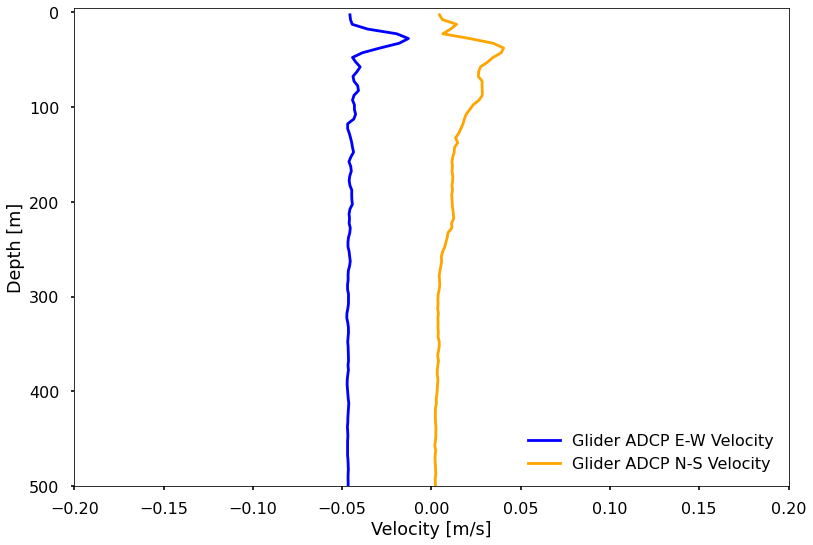

In [64]:
#mean_u = np.nanmean(sub.u.values,axis=(0,2))
#mean_v = np.nanmean(sub.v.values,axis=(0,2))

y =11

sect_adcp_time_ind = np.where((pd.to_datetime(inversion_time).tz_localize(None).values >= sect_times.starttime.values[x]) & (pd.to_datetime(inversion_time).tz_localize(None).values <= sect_times.endtime.values[x]))
inversion_sect_time = inversion_time[sect_adcp_time_ind[0]]
u_grid_sect = u_grid[:,sect_adcp_time_ind[0]]
v_grid_sect = v_grid[:,sect_adcp_time_ind[0]]
inversion_lon_sect = inversion_lon[sect_adcp_time_ind[0]]
inversion_lat_sect = inversion_lat[sect_adcp_time_ind[0]]


plt.plot(np.mean(u_grid_sect,axis=1), inversion_depth, 'blue',label='Glider ADCP E-W Velocity')
plt.plot(np.mean(v_grid_sect,axis=1), inversion_depth, 'orange',label='Glider ADCP N-S Velocity')

#plt.plot(mean_u,sub.depth.values, 'blue', linestyle='dashed',label='RTOFS E-W Velocity')
#plt.plot(mean_v,sub.depth.values, 'orange', linestyle='dashed',label='RTOFS N-S Velocity')
plt.legend(loc='lower right', frameon=False)
plt.xlabel('Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xlim(-0.2,0.2)
plt.ylim(500,-5)

In [ ]:
y =7

subset = df.sel(time=slice(sect_times.starttime.values[y], sect_times.endtime.values[y]))
gl_sect = gl[(gl.start_tm.values > sect_times.starttime.values[y]) & (gl.end_tm.values < sect_times.endtime.values[y])]
tm_ind = np.where((pd.to_datetime(gl_tm).tz_localize(None) >= sect_times.starttime.values[y]) & (pd.to_datetime(gl_tm).tz_localize(None) <= sect_times.endtime.values[y]))
#tm_ind

#x = 0

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
#ax4 = ax1.twiny()



#lns1 = ax1.plot(np.mean(subset.inverted_u,axis=1), subset.depth, 'blue',label='Mean E-W Velocity')
#lns2 = ax1.plot(np.mean(subset.inverted_v,axis=1), subset.depth, 'orange',label='Mean N-S Velocity')


lns1 = ax1.plot(mean_u,sub.depth.values, 'blue', label='RTOFS E-W Velocity')
lns2 = ax1.plot(mean_v,sub.depth.values, 'orange', label='RTOFS N-S Velocity')

ax1.set_xlabel('Velocity [m/s]')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(500,0)
#ax1.set_xticks([-0.15,-0.025,0,0.025,0.05])


lns3 = ax2.plot(np.nanmean(gl_temp[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, 'k', label = 'Mean Glider Temperature')
lns4 = ax3.plot(np.nanmean(gl_salinity[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, '--k', label = 'Mean Glider Salinity')
#lns5 = ax4.plot(np.nanmean(gl_density[:,np.arange(tm_ind[0][0],tm_ind[0][-1])],axis=1),gl_depth, ':k', label = 'Mean Glider Density')


ax2.set_xlim(10,30)
ax2.set_xlabel('Temperature [\N{DEGREE SIGN}C]')
ax3.spines.top.set_position(("axes", 1.15))
ax3.set_xlabel('Salinity [PSU]')
#ax4.spines.top.set_position(("axes", 1.35))
#ax4.set_xlabel('Density [kg/m$^3$]')
#ax4.set_xlim(1021.8,1028)

# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='lower right',frameon=False)

/tmp/ipykernel_29435/583060565.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(inversion_lat_sect,inversion_depth,u_grid_sect,cmap='RdBu',vmin=-0.1,vmax=0.1)


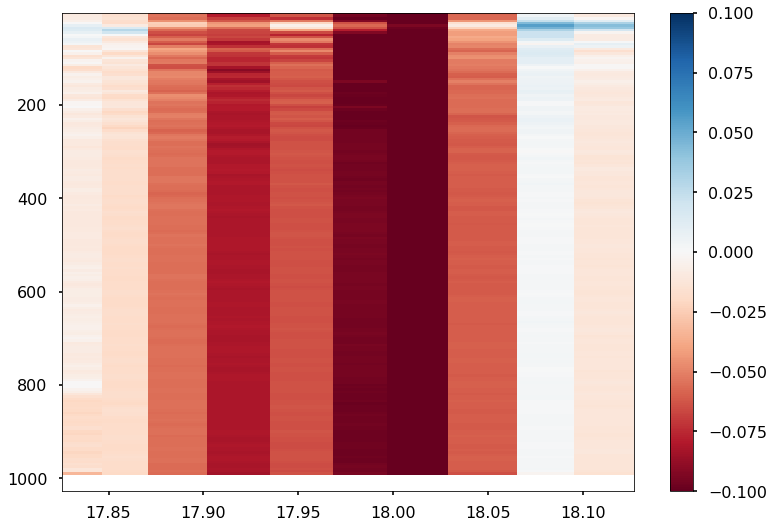

In [83]:
x =9

sect_adcp_time_ind = np.where((pd.to_datetime(inversion_time).tz_localize(None).values >= sect_times.starttime.values[x]) & (pd.to_datetime(inversion_time).tz_localize(None).values <= sect_times.endtime.values[x]))
inversion_sect_time = inversion_time[sect_adcp_time_ind[0]]
u_grid_sect = u_grid[:,sect_adcp_time_ind[0]]
v_grid_sect = v_grid[:,sect_adcp_time_ind[0]]
inversion_lon_sect = inversion_lon[sect_adcp_time_ind[0]]
inversion_lat_sect = inversion_lat[sect_adcp_time_ind[0]]



plt.pcolormesh(inversion_lat_sect,inversion_depth,u_grid_sect,cmap='RdBu',vmin=-0.1,vmax=0.1)
plt.gca().invert_yaxis()
plt.colorbar()

In [80]:
np.arange(7,22)

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])